# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt

import matplotlib.dates as dt

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import time
from datetime import datetime, timedelta


Using TensorFlow backend.


# Load Datasets

In [0]:
df_confirmed = pd.read_csv("drive/My Drive/ECE657A/Coronavirus/time_series_covid19_confirmed_global.csv")
df_recovered = pd.read_csv("drive/My Drive/ECE657A/Coronavirus/time_series_covid19_recovered_global.csv")
df_deaths = pd.read_csv("drive/My Drive/ECE657A/Coronavirus/time_series_covid19_deaths_global.csv")


In [3]:
df_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,4,4,4,4,4,4,4,6,6
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,4,5,5,6,8,10,10,11,15,15,16,17
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15,17,17,19,21,25,26,29,31,35,44,58,86,105
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,6,8,12,14,15,16
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2


# Data preprocessing

We drop the unwanted columns which we won't be using for our neural network computations.

In [0]:
def restructure(df):
    df['Country'] = df['Country/Region'].map(str) + '_' + df['Province/State'].map(str)
    df =  df.drop(['Province/State', 'Country/Region' , 'Lat' , 'Long'], axis=1)
    df = df.set_index('Country')
    df = df.T
    df = df.fillna(0)
    return df

Next, we take each dataset for confirmed cases, recovered cases and deaths and convert them into a time-series dataframe

In [0]:
# Create dataframes for each category
confirmed = restructure(df_confirmed)
confirmed.index = pd.to_datetime(confirmed.index)

recovered = restructure(df_recovered)
recovered.index = pd.to_datetime(recovered.index)

deaths = restructure(df_deaths)
deaths.index = pd.to_datetime(deaths.index)

# Create dataframes for the world
world_conf = confirmed.sum(axis=1)
world_recv = recovered.sum(axis=1)
world_dead = deaths.sum(axis=1)

In [177]:
world_conf.tail()

2020-03-30     782365
2020-03-31     857487
2020-04-01     932605
2020-04-02    1013157
2020-04-03    1095917
dtype: int64

# Plots

We plot the cases in 3 countries and also plot total worldwide cases

In [0]:
# Creating a new dataframe for Countries
italy = pd.DataFrame()
india = pd.DataFrame()
germany = pd.DataFrame()

italy['Confirmed'] = confirmed['Italy_nan']
italy['Recovered'] = recovered['Italy_nan']
italy['Deaths'] = deaths['Italy_nan']


india['Confirmed'] = confirmed['India_nan']
india['Recovered'] = recovered['India_nan']
india['Deaths'] = deaths['India_nan']

germany['Confirmed'] = confirmed['Germany_nan']
germany['Recovered'] = recovered['Germany_nan']
germany['Deaths'] = deaths['Germany_nan']



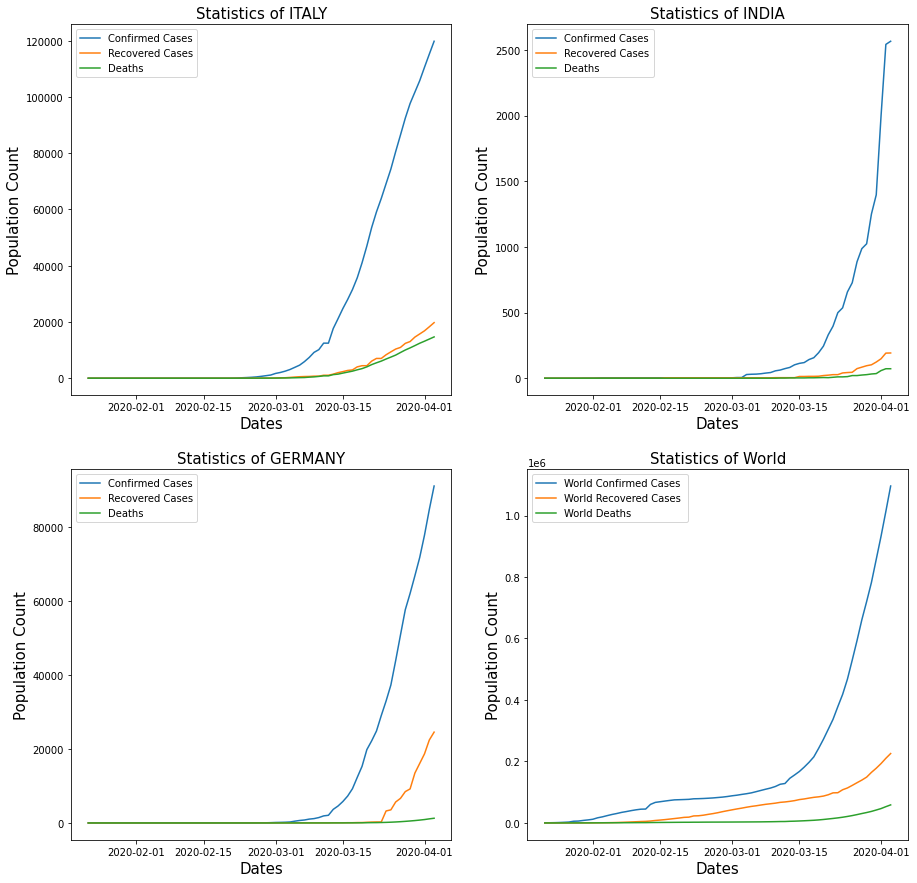

In [284]:
# Plots for Italy, India, Germany and The WORLD
fig = plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.plot(italy.Confirmed, label='Confirmed Cases')
plt.plot(italy.Recovered, label='Recovered Cases')
plt.plot(italy.Deaths, label='Deaths')
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Population Count', fontsize=15)
plt.title('Statistics of ITALY', fontsize=15)
plt.legend()

plt.subplot(2,2,2)
plt.plot(india.Confirmed, label='Confirmed Cases')
plt.plot(india.Recovered, label='Recovered Cases')
plt.plot(india.Deaths, label='Deaths')
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Population Count', fontsize=15)
plt.title('Statistics of INDIA', fontsize=15)
plt.legend()

plt.subplot(2,2,3)
plt.plot(germany.Confirmed, label='Confirmed Cases')
plt.plot(germany.Recovered, label='Recovered Cases')
plt.plot(germany.Deaths, label='Deaths')
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Population Count', fontsize=15)
plt.title('Statistics of GERMANY', fontsize=15)
plt.legend()

plt.subplot(2,2,4)
plt.plot(world_conf.iloc[:], label='World Confirmed Cases ')
plt.plot(world_recv.iloc[:], label='World Recovered Cases')
plt.plot(world_dead.iloc[:], label='World Deaths')
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Population Count', fontsize=15)
plt.title('Statistics of World', fontsize=15)
plt.legend()

Now we plot Global Top 10 regions in each category

Text(0.5, 1.0, 'Deaths in most affected areas')

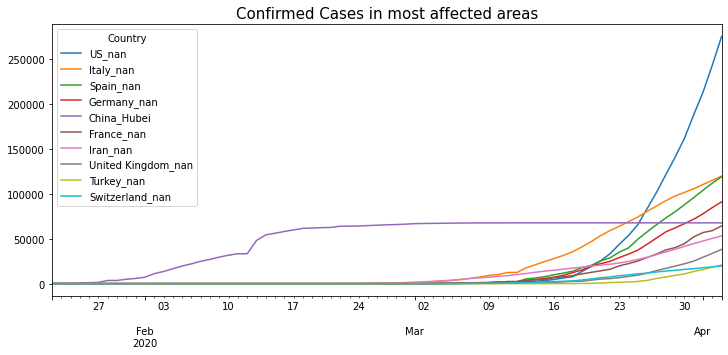

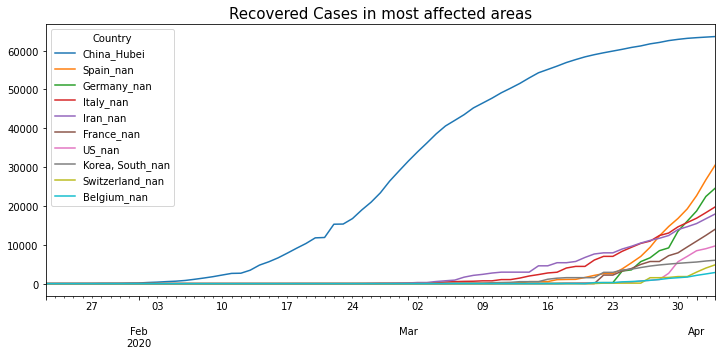

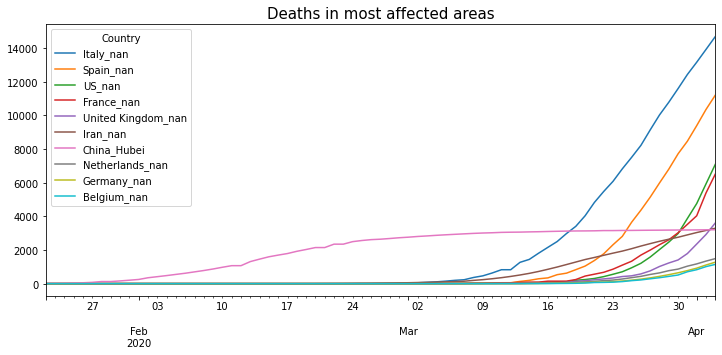

In [82]:
# Plot Global top 10 regions

# fig = plt.figure(figsize=(12,18))

conf_sort = confirmed.reindex(confirmed.max().sort_values(ascending=False).index, axis=1)
conf_top = conf_sort.iloc[:,0:10]

rec_sort = recovered.reindex(recovered.max().sort_values(ascending=False).index, axis=1)
rec_top = rec_sort.iloc[:,0:10]

dead_sort = deaths.reindex(deaths.max().sort_values(ascending=False).index, axis=1)
dead_top = dead_sort.iloc[:,0:10]

conf_top.plot(figsize=(12,5))
plt.title('Confirmed Cases in most affected areas', fontsize=15)

rec_top.plot(figsize=(12,5))
plt.title('Recovered Cases in most affected areas', fontsize=15)

dead_top.plot(figsize=(12,5))
plt.title('Deaths in most affected areas', fontsize=15)

# Italy

Here, we will be training an LSTM Model on our time-series data.
We will split our data in each category into train and test. <br>
Then we will try training our model and plot the predicted train and test values. <br>
Once satisfied with the performance, we will use the same model to compute future trends and predict the spread of virus among the population for a set number of days.

In [283]:
italy.tail()

,Confirmed,Recovered,Deaths
2020-03-30,101739,14620,11591
2020-03-31,105792,15729,12428
2020-04-01,110574,16847,13155
2020-04-02,115242,18278,13915
2020-04-03,119827,19758,14681


In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    print(len(dataset))
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
        
    return np.array(dataX), np.array(dataY)

In [0]:
italy_confirmed = italy.iloc[:,0]

italy_recovered = italy.iloc[:,1]

italy_dead = italy.iloc[:,2]

### For Confirmed Cases

In [86]:
# Split the series for training and testing
size = italy_confirmed.shape[0]
tr =int(round(size*0.8))
X_train, X_test = italy_confirmed[:tr] , italy_confirmed[tr:]

# Reshape the series for further computations
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

# Create train and test windows
look_back = 6
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)

# reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


58
15


Train the LSTM Model

In [87]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(200, input_shape=(1, look_back), activation='relu', dropout=0.2))

model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
model.summary()

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(loss='mean_squared_error', optimizer=opt)

start = time.time()
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)
end = time.time()

runtime = end-start
print('Runtime: ', runtime, 'seconds')

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 200)               165600    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 165,801
Trainable params: 165,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
51/51 [==============================] - 0s 9ms/step - loss: 59479939.8943
Epoch 2/100
51/51 [==============================] - 0s 4ms/step - loss: 3736766.1410
Epoch 3/100
51/51 [==============================] - 0s 5ms/step - loss: 6375519.9024
Epoch 4/100
51/51 [==============================] - 0s 5ms/step - loss: 2683003.5513
Epoch 5/100
51/51 [==============================] - 0s 4ms/step - loss: 3327011.3711
Epoch 6/100
51/51 [==============================] - 0s 4ms/step - loss: 624861

In [0]:
# Make predictions using LSTM Model
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
size = len(italy_confirmed)

# Create NULL arrays
trainPredictPlot = np.zeros(size)
testPredictPlot = np.zeros(size)

for i in range(size):
    trainPredictPlot[i] = np.nan
    testPredictPlot[i] = np.nan

# Add predicted values to new arrays

for i in range(len(trainPredict)):
    trainPredictPlot[look_back + i] = trainPredict[i]

for i in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+(look_back*2)+ i : size-1] = testPredict[i]

# Create Dataframes for each and merge everything
trainPredictPlot = pd.DataFrame(trainPredictPlot, columns=['Train Predictions'])
testPredictPlot = pd.DataFrame(testPredictPlot, columns=['Test Predictions'])

italy_conf = pd.DataFrame(italy_confirmed.values.astype("float"), columns=['Actual Confirmed'])
italy_conf = italy_conf.join(trainPredictPlot)
italy_conf = italy_conf.join(testPredictPlot)
italy_conf.index = italy_confirmed.index

### Future predictions

In [0]:
dates_range = 15
italy_conf_preds= italy_confirmed.copy()
length = italy_confirmed.shape[0]
italy_conf_preds = italy_conf_preds.reset_index()

preds = np.zeros(dates_range)
datelist = pd.date_range(italy.index[-1], periods=31)

for i in range(dates_range-1):
    col = italy_conf_preds['Confirmed']
    value = col[-look_back:]
    value = value.values.reshape(1, 1, look_back)
    preds = model.predict(value)
    df = pd.DataFrame([[datelist[i+1], preds[0,0]]], columns=['index', 'Confirmed'] )
    italy_conf_preds = italy_conf_preds.append(df, ignore_index=True)

italy_conf_preds = italy_conf_preds.set_index('index')

In [282]:
italy_conf_preds.tail()

,Confirmed
index,
2020-04-13,209403.578125
2020-04-14,220640.828125
2020-04-15,232823.390625
2020-04-16,245885.531250
2020-04-17,259548.000000


### For Recovered Cases

In [91]:
# Split the series for training and testing
size = italy_recovered.shape[0]
tr =int(round(size*0.8))
X_train, X_test = italy_recovered[:tr] , italy_recovered[tr:]

# Reshape the series for further computations
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)


# Create Windows
look_back = 6
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)

# reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

58
15


In [92]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(200, input_shape=(1, look_back), activation='relu', dropout=0.2))

model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
model.summary()

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(loss='mean_squared_error', optimizer=opt)

start = time.time()
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)
end = time.time()

runtime = end-start
print('Runtime: ', runtime, 'seconds')

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 200)               165600    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 165,801
Trainable params: 165,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
51/51 [==============================] - 0s 8ms/step - loss: 759562.6651
Epoch 2/100
51/51 [==============================] - 0s 4ms/step - loss: 152150.2460
Epoch 3/100
51/51 [==============================] - 0s 4ms/step - loss: 54537.2307
Epoch 4/100
51/51 [==============================] - 0s 4ms/step - loss: 70963.1032
Epoch 5/100
51/51 [==============================] - 0s 4ms/step - loss: 113470.6512
Epoch 6/100
51/51 [==============================] - 0s 4ms/step - loss: 41563.0164
Epo

In [0]:
# Make predictions using LSTM Model
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
size = len(italy_recovered)

# Create NULL arrays
trainPredictPlot = np.zeros(size)
testPredictPlot = np.zeros(size)

for i in range(size):
    trainPredictPlot[i] = np.nan
    testPredictPlot[i] = np.nan

# Add predicted values to new arrays

for i in range(len(trainPredict)):
    trainPredictPlot[look_back + i] = trainPredict[i]

for i in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+(look_back*2)+ i : len(italy_recovered)-1] = testPredict[i]

# Create Dataframes for each and merge everything
trainPredictPlot = pd.DataFrame(trainPredictPlot, columns=['Train Predictions'])
testPredictPlot = pd.DataFrame(testPredictPlot, columns=['Test Predictions'])

italy_recv = pd.DataFrame(italy_recovered.values.astype("float"), columns=['Actual Confirmed'])
italy_recv = italy_recv.join(trainPredictPlot)
italy_recv = italy_recv.join(testPredictPlot)
italy_recv.index = italy_recovered.index

### Future Predictions

In [0]:
dates_range = 15
italy_recv_preds= italy_recovered.copy()
length = italy_recovered.shape[0]
italy_recv_preds = italy_recv_preds.reset_index()

preds = np.zeros(dates_range)
datelist = pd.date_range(italy.index[-1], periods=31)

for i in range(dates_range-1):
    col = italy_recv_preds['Recovered']
    value = col[-look_back:]
    value = value.values.reshape(1, 1, look_back)
    preds = model.predict(value)
    df = pd.DataFrame([[datelist[i+1], preds[0,0]]], columns=['index', 'Recovered'] )
    italy_recv_preds = italy_recv_preds.append(df, ignore_index=True)

italy_recv_preds = italy_recv_preds.set_index('index')

In [281]:
italy_recv_preds.tail()

,Recovered
index,
2020-04-13,55032.839844
2020-04-14,60827.539062
2020-04-15,67236.679688
2020-04-16,74316.562500
2020-04-17,82134.148438


### For Deaths

In [96]:
# Split the series for training and testing
size = italy_dead.shape[0]
tr =int(round(size*0.8))
X_train, X_test = italy_dead[:tr] , italy_dead[tr:]

# Reshape the series for further computations
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)


# Create windows
look_back = 6
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)

# reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

58
15


In [97]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(200, input_shape=(1, look_back), activation='relu', dropout=0.2))

model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
model.summary()

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(loss='mean_squared_error', optimizer=opt)

start = time.time()
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)
end = time.time()

runtime = end-start
print('Runtime: ', runtime, 'seconds')

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 200)               165600    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 165,801
Trainable params: 165,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
51/51 [==============================] - 0s 8ms/step - loss: 365235.5357
Epoch 2/100
51/51 [==============================] - 0s 5ms/step - loss: 181720.4224
Epoch 3/100
51/51 [==============================] - 0s 4ms/step - loss: 23577.3839
Epoch 4/100
51/51 [==============================] - 0s 4ms/step - loss: 29104.7622
Epoch 5/100
51/51 [==============================] - 0s 4ms/step - loss: 32037.8880
Epoch 6/100
51/51 [==============================] - 0s 4ms/step - loss: 25022.7491
Epoc

In [0]:
# Make predictions using LSTM Model
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
size = len(italy_dead)

# Create NULL arrays
trainPredictPlot = np.zeros(size)
testPredictPlot = np.zeros(size)

for i in range(size):
    trainPredictPlot[i] = np.nan
    testPredictPlot[i] = np.nan

# Add predicted values to new arrays

for i in range(len(trainPredict)):
    trainPredictPlot[look_back + i] = trainPredict[i]

for i in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+(look_back*2)+ i : len(italy_dead)-1] = testPredict[i]

# Create Dataframes for each and merge everything
trainPredictPlot = pd.DataFrame(trainPredictPlot, columns=['Train Predictions'])
testPredictPlot = pd.DataFrame(testPredictPlot, columns=['Test Predictions'])

italy_deads = pd.DataFrame(italy_dead.values.astype("float"), columns=['Actual Deaths'])
italy_deads = italy_deads.join(trainPredictPlot)
italy_deads = italy_deads.join(testPredictPlot)
italy_deads.index = italy_dead.index

### Future Predictions

In [0]:
dates_range = 15
italy_dead_preds= italy_dead.copy()
length = italy_dead.shape[0]
italy_dead_preds = italy_dead_preds.reset_index()

preds = np.zeros(dates_range)
datelist = pd.date_range(italy.index[-1], periods=31)

for i in range(dates_range-1):
    col = italy_dead_preds['Deaths']
    value = col[-look_back:]
    value = value.values.reshape(1, 1, look_back)
    preds = model.predict(value)
    df = pd.DataFrame([[datelist[i+1], preds[0,0]]], columns=['index', 'Deaths'] )
    italy_dead_preds = italy_dead_preds.append(df, ignore_index=True)

italy_dead_preds = italy_dead_preds.set_index('index')

In [280]:
italy_dead_preds.tail()

,Deaths
index,
2020-04-13,42356.132812
2020-04-14,46762.343750
2020-04-15,51643.328125
2020-04-16,57321.335938
2020-04-17,62983.695312


# Plots for Italy

We generate plots for Italy. <br>
On the left, we plotted the Trained and tested predictions with the actual values for each category. <br>

On the right, we plotted the predicted future trends of the virus in Italy along with the actual values. Actual values stop at one point, which is the point until when the data was collected.

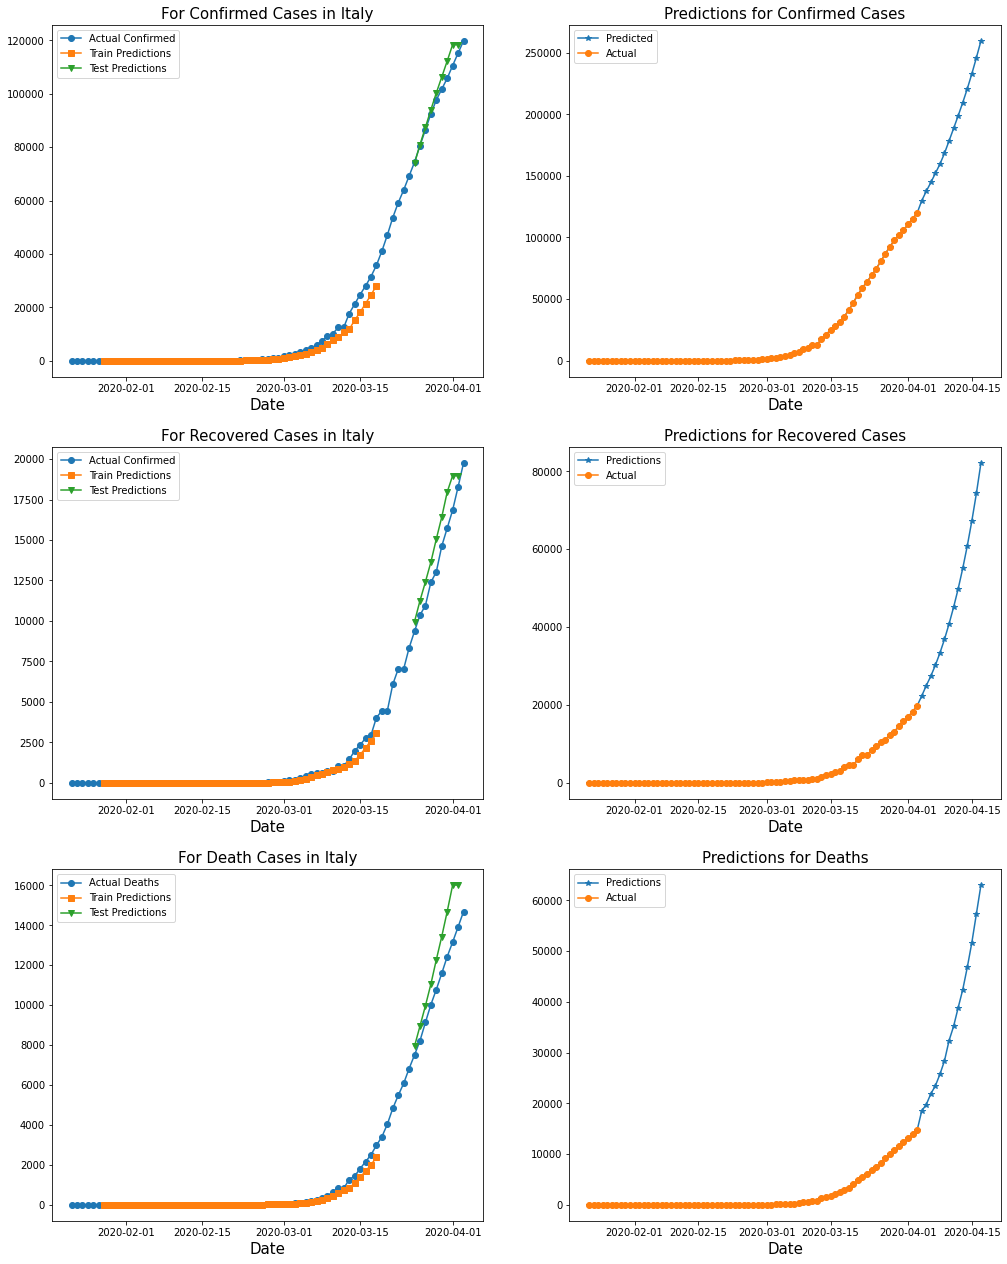

In [100]:
# plot Confirmed actual cases and predictions
fig = plt.figure(figsize=(17,22))

plt.subplot(3,2,1)
plt.plot(italy_conf.iloc[:,0], label=italy_conf.iloc[:,0].name, marker='o')
plt.plot(italy_conf.iloc[:,1], label=italy_conf.iloc[:,1].name, marker='s')
plt.plot(italy_conf.iloc[:,2], label=italy_conf.iloc[:,2].name, marker='v')
plt.xlabel('Date', fontsize=15)
# plt.ylabel('Number of Cases', fontsize=15)
plt.title('For Confirmed Cases in Italy', fontsize=15)
plt.legend()


plt.subplot(3,2,2)
plt.plot(italy_conf_preds.Confirmed, label='Predicted', marker='*')
plt.plot(italy_conf.iloc[:,0], label='Actual', marker='o')
plt.xlabel('Date', fontsize=15)
# plt.ylabel('Number of Cases', fontsize=15)
plt.title('Predictions for Confirmed Cases', fontsize=15)
plt.legend()

# plot Recovered actual cases and predictions
plt.subplot(3,2,3)
plt.plot(italy_recv.iloc[:,0], label=italy_recv.iloc[:,0].name, marker='o')
plt.plot(italy_recv.iloc[:,1], label=italy_recv.iloc[:,1].name, marker='s')
plt.plot(italy_recv.iloc[:,2], label=italy_recv.iloc[:,2].name, marker='v')
plt.xlabel('Date', fontsize=15)
# plt.ylabel('Number of Cases', fontsize=15)
plt.title('For Recovered Cases in Italy', fontsize=15)
plt.legend()

plt.subplot(3,2,4)
plt.plot(italy_recv_preds.Recovered, label='Predictions', marker='*')
plt.plot(italy_recv.iloc[:,0], label='Actual', marker='o')
plt.xlabel('Date', fontsize=15)
# plt.ylabel('Number of Cases', fontsize=15)
plt.title('Predictions for Recovered Cases', fontsize=15)
plt.legend()

# plot actual Deaths and predictions
plt.subplot(3,2,5)
plt.plot(italy_deads.iloc[:,0], label=italy_deads.iloc[:,0].name, marker='o')
plt.plot(italy_deads.iloc[:,1], label=italy_deads.iloc[:,1].name, marker='s')
plt.plot(italy_deads.iloc[:,2], label=italy_deads.iloc[:,2].name, marker='v')
plt.xlabel('Date', fontsize=15)
# plt.ylabel('Number of Cases', fontsize=15)
plt.title('For Death Cases in Italy', fontsize=15)
plt.legend()

plt.subplot(3,2,6)
plt.plot(italy_dead_preds.Deaths, label='Predictions', marker='*')
plt.plot(italy_deads.iloc[:,0], label='Actual', marker='o')
plt.xlabel('Date', fontsize=15)
plt.title('Predictions for Deaths', fontsize=15)
plt.legend()

# World

Now we shift our focus to the World demographics that are affected by COVID-19. <br>

We tune our LSTM model for the world data, generate predictions and plot those predictions against the actual values.<br>
These predictions generated try to foresee the next 20 days of disease spread, until April 22, 2020.

In [0]:
world_confirmed = pd.DataFrame(world_conf)
world_confirmed = world_confirmed.rename(columns={0: 'Confirmed'})

world_recovered = pd.DataFrame(world_recv)
world_recovered = world_recovered.rename(columns={0: 'Recovered'})

world_dead = pd.DataFrame(world_dead)
world_dead = world_dead.rename(columns={0: 'Deaths'})


In [178]:
world_confirmed.tail()

,Confirmed
2020-03-30,782365
2020-03-31,857487
2020-04-01,932605
2020-04-02,1013157
2020-04-03,1095917


## For Worldwide Confirmed Cases

In [239]:
# Split the series for training and testing
size = world_confirmed.shape[0]
tr =int(round(size*0.8))
X_train, X_test = world_confirmed[:tr] , world_confirmed[tr:]

# Reshape the series for further computations
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

# Create train and test windows
look_back = 12
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)

# reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


58
15


In [240]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(15, input_shape=(1, look_back), activation='relu', dropout=0.3))

model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
model.summary()

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(loss='mean_squared_error', optimizer=opt)

start = time.time()
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)
end = time.time()

runtime = end-start
print('Runtime: ', runtime, 'seconds')

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 15)                1680      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 16        
Total params: 1,696
Trainable params: 1,696
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
45/45 [==============================] - 0s 9ms/step - loss: 8022848827.0222
Epoch 2/20
45/45 [==============================] - 0s 5ms/step - loss: 6276465001.9556
Epoch 3/20
45/45 [==============================] - 0s 4ms/step - loss: 3616172942.3111
Epoch 4/20
45/45 [==============================] - 0s 4ms/step - loss: 3001252233.1778
Epoch 5/20
45/45 [==============================] - 0s 4ms/step - loss: 2501862616.5556
Epoch 6/20
45/45 [==============================] - 0s 4ms/step - loss: 1

In [0]:
dates_range = 20
world_conf_preds= world_confirmed.copy()
length = world_confirmed.shape[0]
world_conf_preds = world_conf_preds.reset_index()

preds = np.zeros(dates_range)
datelist = pd.date_range(world_conf.index[-1], periods=dates_range)

for i in range(dates_range-1):
    value = world_conf_preds.iloc[:,1][-look_back:]
    value = value.values.reshape(1, 1, look_back)
    preds = model.predict(value)
    df = pd.DataFrame([[datelist[i+1], preds[0,0]]], columns=['index', 'Confirmed'] )
    world_conf_preds = world_conf_preds.append(df, ignore_index=True)

world_conf_preds = world_conf_preds.set_index('index')

In [245]:
world_conf_preds.tail()

,Confirmed
index,
2020-04-18,1647196.500
2020-04-19,1704498.625
2020-04-20,1750864.875
2020-04-21,1842224.875
2020-04-22,1900902.875


## For Worldwide Recovered Cases

In [247]:
# Split the series for training and testing
size = world_recovered.shape[0]
tr =int(round(size*0.8))
X_train, X_test = world_recovered[:tr] , world_recovered[tr:]

# Reshape the series for further computations
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

# Create train and test windows
look_back = 12
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)

# reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


58
15


In [254]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(40, input_shape=(1, look_back), activation='relu', dropout=0.2))

model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
model.summary()

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(loss='mean_squared_error', optimizer=opt)

start = time.time()
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)
end = time.time()

runtime = end-start
print('Runtime: ', runtime, 'seconds')

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 40)                8480      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 41        
Total params: 8,521
Trainable params: 8,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
45/45 [==============================] - 0s 9ms/step - loss: 1818710655.0049
Epoch 2/20
45/45 [==============================] - 0s 4ms/step - loss: 1260595581.3278
Epoch 3/20
45/45 [==============================] - 0s 4ms/step - loss: 591302497.2069
Epoch 4/20
45/45 [==============================] - 0s 4ms/step - loss: 224676783.7660
Epoch 5/20
45/45 [==============================] - 0s 4ms/step - loss: 99297322.6931
Epoch 6/20
45/45 [==============================] - 0s 4ms/step - loss: 90087

In [0]:
dates_range = 20
world_recv_preds= world_recovered.copy()
length = world_recovered.shape[0]
world_recv_preds = world_recv_preds.reset_index()

preds = np.zeros(dates_range)
datelist = pd.date_range(world_recv.index[-1], periods=dates_range)

for i in range(dates_range-1):
    value = world_recv_preds.iloc[:,1][-look_back:]
    value = value.values.reshape(1, 1, look_back)
    preds = model.predict(value)
    df = pd.DataFrame([[datelist[i+1], preds[0,0]]], columns=['index', 'Recovered'] )
    world_recv_preds = world_recv_preds.append(df, ignore_index=True)

world_recv_preds = world_recv_preds.set_index('index')

In [279]:
world_recv_preds.tail()

,Recovered
index,
2020-04-18,384228.90625
2020-04-19,401151.21875
2020-04-20,419013.09375
2020-04-21,437660.37500
2020-04-22,457194.18750


## For Worldwide Deaths

In [258]:
# Split the series for training and testing
size = world_dead.shape[0]
tr =int(round(size*0.8))
X_train, X_test = world_dead[:tr] , world_dead[tr:]

# Reshape the series for further computations
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

# Create train and test windows
look_back = 12
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(X_test, look_back)

# reshape input to be [samples, time steps, features] for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


58
15


In [270]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(35, input_shape=(1, look_back), activation='relu', dropout=0.2))

model.add(Dense(1, activation=LeakyReLU(alpha=0.1)))
model.summary()

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(loss='mean_squared_error', optimizer=opt)

start = time.time()
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)
end = time.time()

runtime = end-start
print('Runtime: ', runtime, 'seconds')

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 35)                5880      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 36        
Total params: 5,916
Trainable params: 5,916
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
51/51 [==============================] - 0s 9ms/step - loss: 8924259.3184
Epoch 2/20
51/51 [==============================] - 0s 4ms/step - loss: 3934579.4637
Epoch 3/20
51/51 [==============================] - 0s 4ms/step - loss: 1982528.0863
Epoch 4/20
51/51 [==============================] - 0s 4ms/step - loss: 1279093.8612
Epoch 5/20
51/51 [==============================] - 0s 4ms/step - loss: 943188.4154
Epoch 6/20
51/51 [==============================] - 0s 4ms/step - loss: 1249985.5965
Epoc

In [0]:
dates_range = 20
world_dead_preds= world_dead.copy()
length = world_dead.shape[0]
world_dead_preds = world_dead_preds.reset_index()

preds = np.zeros(dates_range)
datelist = pd.date_range(world_dead.index[-1], periods=dates_range)

for i in range(dates_range-1):
    value = world_dead_preds.iloc[:,1][-look_back:]
    value = value.values.reshape(1, 1, look_back)
    preds = model.predict(value)
    df = pd.DataFrame([[datelist[i+1], preds[0,0]]], columns=['index', 'Deaths'] )
    world_dead_preds = world_dead_preds.append(df, ignore_index=True)

world_dead_preds = world_dead_preds.set_index('index')

In [278]:
world_dead_preds.tail()

,Deaths
index,
2020-04-18,100591.414062
2020-04-19,104932.687500
2020-04-20,109492.945312
2020-04-21,114274.890625
2020-04-22,119250.453125


# Plots for the World

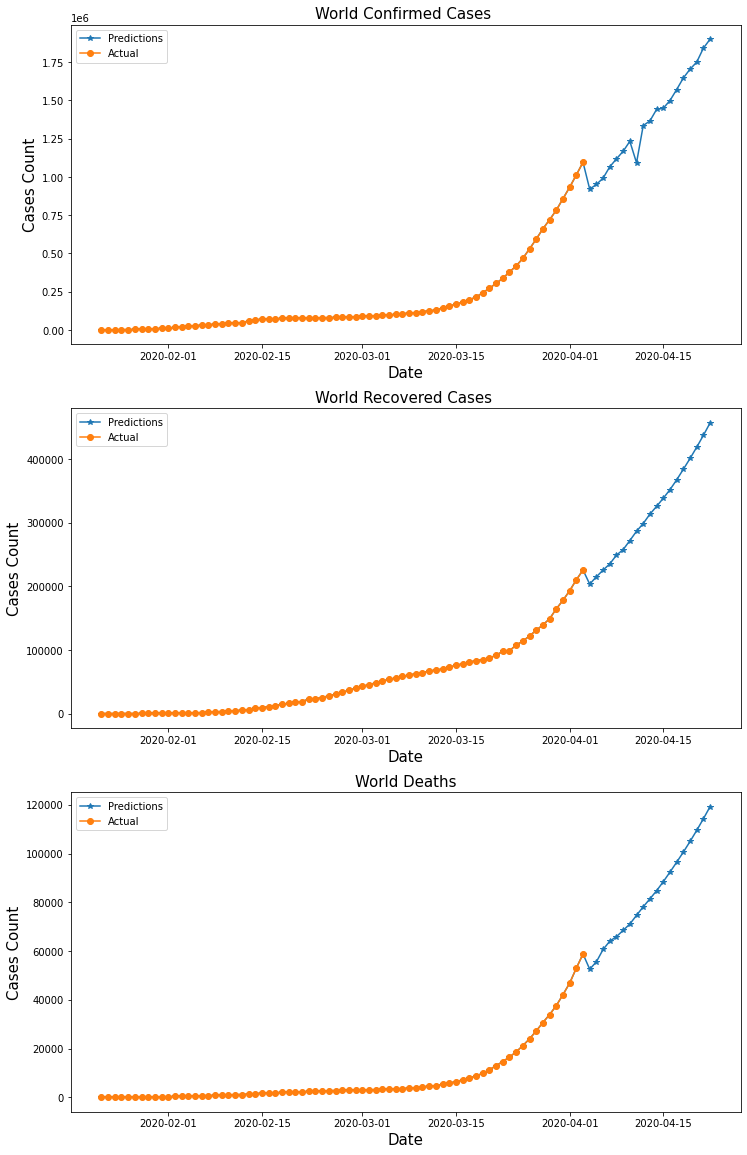

In [277]:
# plot Confirmed actual cases and predictions
fig = plt.figure(figsize=(12,20))

plt.subplot(3,1,1)
plt.plot(world_conf_preds['Confirmed'], label='Predictions', marker='*')
plt.plot(world_confirmed['Confirmed'], label='Actual', marker='o')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Cases Count', fontsize=15)
plt.title('World Confirmed Cases ', fontsize=15)
plt.legend()


plt.subplot(3,1,2)
plt.plot(world_recv_preds['Recovered'], label='Predictions', marker='*')
plt.plot(world_recovered['Recovered'], label='Actual', marker='o')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Cases Count', fontsize=15)
plt.title('World Recovered Cases ', fontsize=15)
plt.legend()

plt.subplot(3,1,3)
plt.plot(world_dead_preds['Deaths'], label='Predictions', marker='*')
plt.plot(world_dead['Deaths'], label='Actual', marker='o')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Cases Count', fontsize=15)
plt.title('World Deaths', fontsize=15)
plt.legend()

# Final Thoughts




*   Our Final Day in the predictions generated is April 22, 2020, which coincidentally was the day of submission of this assignment.

*  We used this opportunity to compare our model to real world data and draw insightful comparisons.


*   The Prediction plots of Italy overestimate the spread of the virus. They predict far more confirmed cases, recovered cases and deaths than in real life.

*   But out model does a good job of estimating the increasing trend that is observed in real life as well.


*   For the World Predictions, we notice a similar trend that is happening in the world right now.

*   The numbers are continuing to increase, but let's hope that our model is wrong and this pandemic ends soon!





